In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Question 1

In [2]:
def apply_frequency_filter(image, filter_type='ideal', pass_type='low', D0=50, n=2):
    # Convert  to float and normalize
    img = image.astype(np.float32) / 255.0
    M, N = img.shape

    # 2D FT and shift the zero-frequency component to the center
    F = np.fft.fftshift(np.fft.fft2(img))

    # Frequency grid
    u, v = np.meshgrid(np.arange(-M//2, M//2), np.arange(-N//2, N//2), indexing='ij')
    D = np.sqrt(u**2 + v**2)

    # Construct filter (LPF)
    if filter_type == 'ideal':
        H = np.double(D <= D0)
    elif filter_type == 'gaussian':
        H = np.exp(-(D**2) / (2 * (D0**2)))
    elif filter_type == 'butterworth':
        H = 1 / (1 + (D / D0)**(2 * n))
    else:
        raise ValueError("filter_type must be 'ideal', 'gaussian', or 'butterworth'")

    # High-pass filter: complement of low-pass
    if pass_type == 'high':
        H = 1 - H

    # Apply filter in frequency domain (correlated in time domain, multiplied in frequency domain)
    G = F * H

    # Inverse and shift back
    g = np.real(np.fft.ifft2(np.fft.ifftshift(G)))

    # rescaling
    g = np.clip(g, 0, 1)
    return g


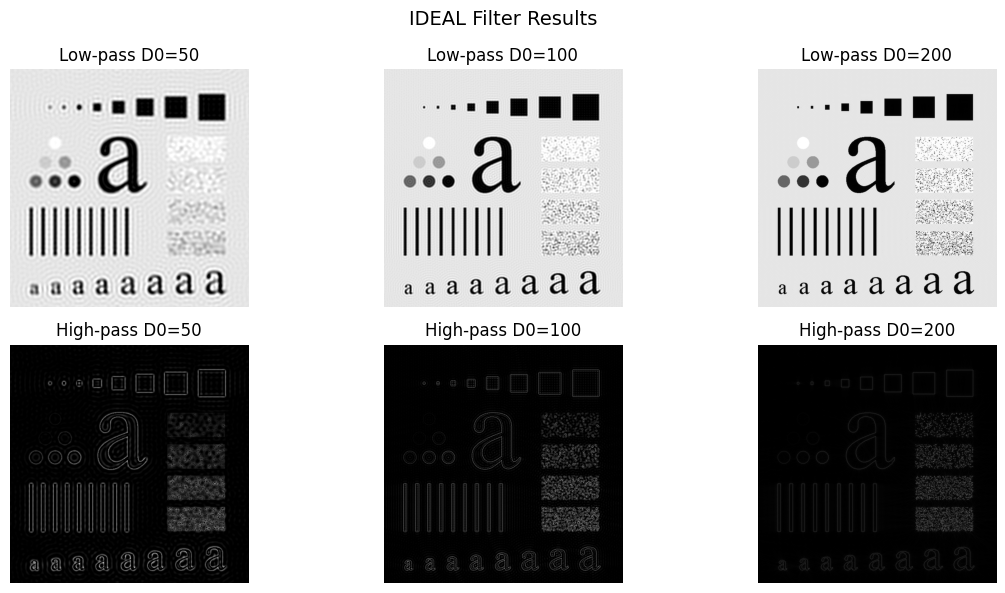

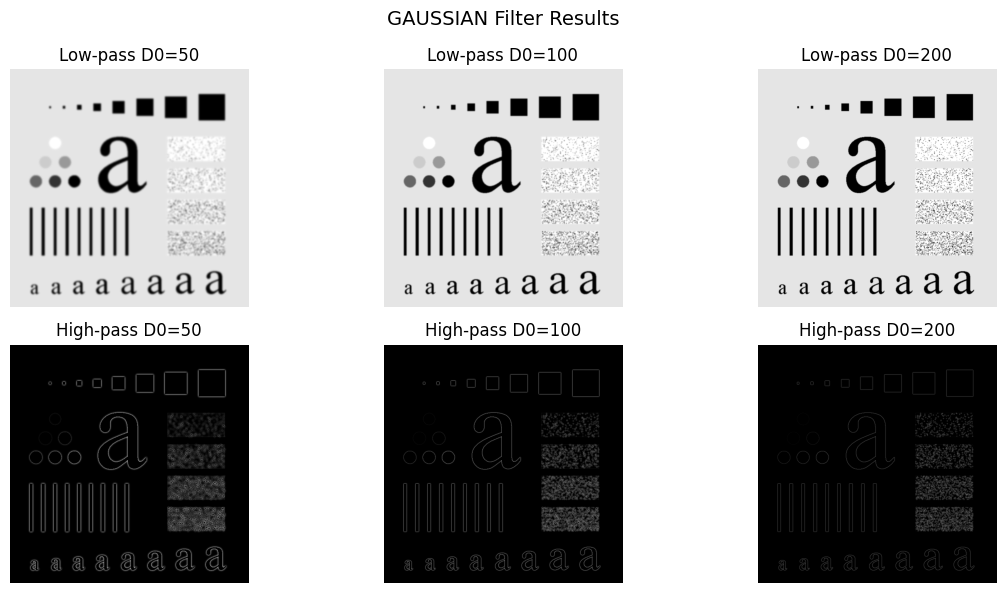

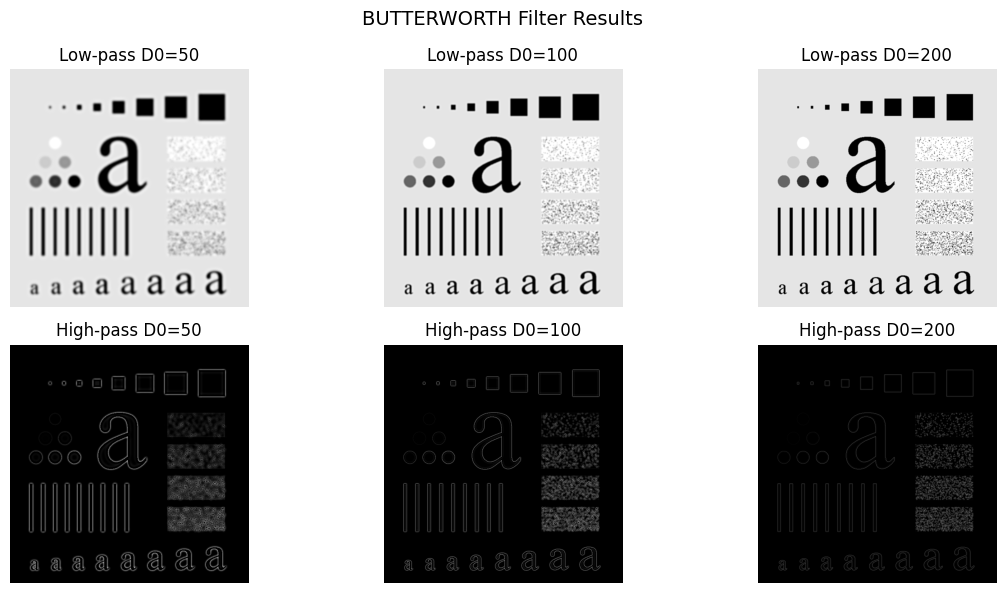

In [3]:
img = cv2.imread('a.tif', cv2.IMREAD_GRAYSCALE)

# parameters
kernel = [50, 100, 200]
filters = ['ideal', 'gaussian', 'butterworth']

for ftype in filters:
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'{ftype.upper()} Filter Results', fontsize=14)

    for i, D0 in enumerate(kernel):
        low = apply_frequency_filter(img, ftype, 'low', D0)
        high = apply_frequency_filter(img, ftype, 'high', D0)

        # LPF
        plt.subplot(2, len(kernel), i + 1)
        plt.imshow(low, cmap='gray')
        plt.title(f'Low-pass D0={D0}')
        plt.axis('off')

        # HPF
        plt.subplot(2, len(kernel), i + 1 + len(kernel))
        plt.imshow(high, cmap='gray')
        plt.title(f'High-pass D0={D0}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

1. Fourier Transform of an Image

$\[F(u, v) = \sum_{x=0}^{M-1}\sum_{y=0}^{N-1} f(x, y) \, e^{-j2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)}\]$

$\[f(x, y) = \frac{1}{MN} \sum_{u=0}^{M-1}\sum_{v=0}^{N-1} F(u, v) \, e^{j2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)}\]$


2. Frequency Domain Filtering

$\[G(u, v) = H(u, v) \cdot F(u, v)\]$

Then the filtered image is obtained using the inverse Fourier transform:

$\[g(x, y) = \mathcal{F}^{-1}\{ G(u, v) \}\]$

$\[D(u, v) = \sqrt{(u - M/2)^2 + (v - N/2)^2}\]$

3.Filters
- (a) Ideal Low-Pass Filter

$\[H(u, v) =\begin{cases}1, & D(u, v) \leq D_0 \\0, & D(u, v) > D_0\end{cases}\]$

   - Sharp cutoff at $\( D_0 \)$

- (b) Gaussian Low-Pass Filter

$\[H(u, v) = e^{-\frac{D(u,v)^2}{2D_0^2}}\]$

- Smoothly decreases with distance

- (c) Butterworth Low-Pass Filter

$\[H(u, v) = \frac{1}{1 + \left(\frac{D(u,v)}{D_0}\right)^{2n}}\]$

- \( n \): filter order (controls the slope of the transition)
- Smoother than ideal but sharper than Gaussian
- Larger \( n \) → steeper transition

# Question 2

## alef

## be

## pe

## te

## se

# Question 3

## alef

## be

## pe

## te

## se